# Constructing the forward model

This section will cover how to construct the head model (the forward model implemented as a lead field matrix) to be used in source modeling. This will be done based on the structural T1 MRI. To download the scan, go to `Website to be given`.

The model will be alinged to head postion of the subject in the OPM system. Note that this seciton requires access to FreeSurfer (a Unix/Linux software). For more details see` https://mne.tools/stable/auto_tutorials/forward/30_forward.html`

## Preparation

Import the relevant Python modules:

In [9]:
import os.path as op
import mne
from mne_bids import BIDSPath, read_raw_bids
from IPython.display import Image, display
from mne_bids import (
    BIDSPath,
    get_anat_landmarks,
    get_head_mri_trans,
    print_dir_tree,
    write_anat,
    write_raw_bids,
)

## Set the file names and paths

In [43]:
subject = '01'
session = '01'
task = 'SpAtt'
# name of the task
run = '01'
meg_suffix = 'meg'
mri_suffix = 'T1w'
epo_suffix = 'epo'
bem_suffix = 'bem-sol'
src_suffix = 'src'
fwd_suffix = 'fwd'
trans_suffix = 'trans1'

#data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/analysis")

fs_subject = 'T1s'
# name of subject from freesurfer
# Files and directories for input
bids_path = BIDSPath(subject=subject, session=session,
task=task, run=run, suffix=epo_suffix, datatype='meg',
root=deriv_root, extension='.fif', check=False)
raw_path = bids_path.copy().update(root=bids_root,
suffix=meg_suffix, extension='.fif', run='01',check=False)
print("\n*** Input files ***")
print("* Raw fiff-file (with digitization points) :", raw_path)
print("* Epoched file: ",bids_path)


*** Input files ***
* Raw fiff-file (with digitization points) : /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
* Epoched file:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif


## The MRI files 

In [44]:
mri_root = BIDSPath(subject=subject, session=session,
                    root=bids_root,  
                    datatype='anat', suffix=mri_suffix, extension='.nii')
print("* MRI file: ",mri_root) 


#fs_root = 'C:/Users/rakshita/Documents/Cerca_raw_files/Cerca_Spatt_BIDS/derivatives/FreeSurfer'
print("\n*** Output files ***")
fs_root = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer'
print("* Freesurfer directory: ",fs_root)

* MRI file:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/sub-01/ses-01/anat/sub-01_ses-01_T1w.nii

*** Output files ***
* Freesurfer directory:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer


## Output including transformations

In [45]:
# Files and directories for generated output 

print("\n*** Output files ***")

fwd_fname = bids_path.basename.replace(epo_suffix, fwd_suffix)
fwd_file = op.join(bids_path.directory, fwd_fname)
print("* Forward model: ",fwd_file)

src_file = fwd_file.replace(fwd_suffix, src_suffix)
print("* Brain surface file: ",src_file)

trans_file = fwd_file.replace(fwd_suffix, trans_suffix)
print("* Tranformation file: ",trans_file)

bem_file = fwd_file.replace(fwd_suffix, bem_suffix)
print("* Boundary element file: ",bem_file)


*** Output files ***
* Forward model:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_fwd.fif
* Brain surface file:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_src.fif
* Tranformation file:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_trans1.fif
* Boundary element file:  /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_bem-sol.fif


## Perform surface reconstruction using FreeSurfer and MNE

A first requirement is that the MRI data are in NifTI (.nii) format. Conversion from DICOM to NifTI can be done e.g. using MRIcro or  dcm2niix.

The NifTI file for this tutorial is T1s.nii.gz . 

FreeSurfer provides the functionality for performing the cortical reconstuction using the recon-all.

This must be done in Unix/Linux:

    recon-all -i T1_anon_defaced.nii -s T1_anon_defaced -all

To perform the scalp surface reconstruction to be used in MNE-Python using the command from the terminal:

    mne make_scalp_surfaces --overwrite --subject T1_anon_defaced --force

To create the BEM, execute the terminal command:

    mne watershed_bem --overwrite --subject t1_anon_defaced

For a convinient batch script performing these commands see my_recon.sh on GitHub

The next step is to read and illustrate the brain surface generated from FreeSurfer.


## Inspecting the surface reconstruction

In order to verify that the surface has been constructed and the fif-file created plot the output:

In [46]:
%matplotlib inline
Brain = mne.viz.get_brain_class()

brain = Brain(fs_subject, 
              hemi='lh', 
              surf='pial',
              subjects_dir=fs_root, 
              size=(800, 600))

brain.add_annotation('aparc.a2009s', borders=False)

<img src="https://raw.githubusercontent.com/FLUX-pipeline/Cerca/main/brain1.png" width="600">

Above shows the parcellated brain surface. We are not going to use the parcellation here; however, it is wise to use the output to check that the brain surface has been correctly reconstructed.

## Creating the boundary element model (BEM) surfaces

Now that the surface of the MRI has been recontructed the boundary element model (BEM) can be created. As this will be used for MEG source reconstruction, we will prepare a single shell model by setting *conductivity = (0.3)* . The ico parameter serves to downsample the model and it can be increased to reduce the computational demands.

In [47]:
conductivity = (0.3,) 
model = mne.make_bem_model(fs_subject,
                           ico=4,
                           conductivity=conductivity,
                           subjects_dir=fs_root)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -1.53 -19.88  23.34 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Now save the BEM model:

In [48]:
mne.write_bem_solution(bem_file, bem, overwrite=True)

Overwriting existing file.


and visualize

Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/inner_skull.surf
Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/outer_skull.surf
Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/outer_skin.surf


/Users/o.jensen@bham.ac.uk/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


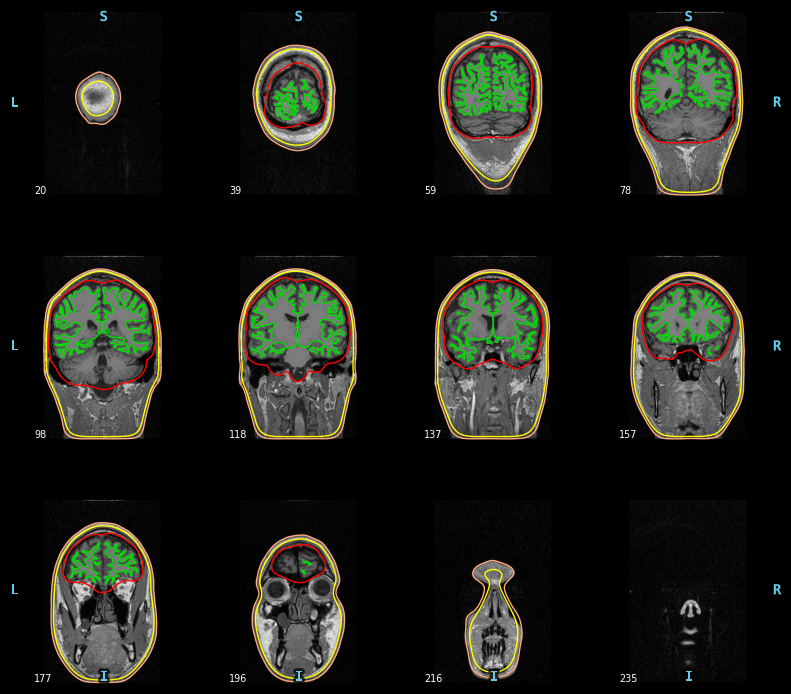

In [50]:
mne.viz.plot_bem(subject=fs_subject,
                subjects_dir=fs_root,
                brain_surfaces='white',
                orientation='coronal');

In the above plots please check that the brain surface has been identified correctly.

## Co-registration with anatomical landmarks

The device-to-head transformation, based on digitized scalp landmarks obtained from the 3D scan, is performed using the inbuilt Cerca software. In this study, we did not use HPI coils. The next step is to align the head (in sensor space) with the MRI anatomical space. This spatial alignment is essential for computing the forward solution. To perform this alignment, the MNE-Python coregistration GUI is used, which allows us to visually match the digitized head shape and fiducial points to the MRI surface. For more details on it, please refer to the following video: https://youtu.be/ALV5qqMHLlQ. The output of this manual coregistration process is a transformation file that will be used later in the analysis pipeline.

For the file to save used the name from trans_file:

In [51]:
print(trans_file)

/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_trans1.fif


For the raw fiff-file with digitized data use <raw_path>:

In [52]:
print(raw_path)

/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif


Load the fif file

In [55]:
raw = mne.io.read_raw_fif(raw_path, preload=False)

Opening raw data file /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif...
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.


In [73]:
%matplotlib qt
mne.gui.coregistration(subject=fs_subject, subjects_dir=fs_root);

Using high resolution head model in /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/T1s-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/T1s-fiducials.fif.
Using high resolution head model in /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/T1s-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/T1s-fiducials.fif.
Loading MRI fiducials from /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/T1s-fiducials.fif... Done!
Using T1s-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Loading MRI fiducials from /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cer

## Computing the sources according to the BEM model

To construct volumetric forward model, the 'source space' must be set up. The source space is defined by a grid (5 mm between grid points) covering the volume of the brain.

In [57]:
surface = op.join(fs_root, fs_subject, 'bem', 'inner_skull.surf')
src = mne.setup_volume_source_space(fs_subject, subjects_dir=fs_root,
                                     surface=surface,
                                     verbose=True)

Boundary surface file : /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/inner_skull.surf
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/mri/T1.mgz

Reading /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/mri/T1.mgz...

Loaded bounding surface from /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/inner_skull.surf (10242 nodes)
Surface CM = (  -1.5  -19.9   23.3) mm
Surface fits inside a sphere with radius  100.0 mm
Surface extent:
    x =  -75.0 ...   72.5 mm
    y = -104.0 ...   79.0 mm
    z =  -58.6 ...   95.9 mm
Grid extent:
    x =  -75.0 ...   75.0 mm
    y = -105.0 ...   80.0 mm
    z =  -60.0 ...  100.0 mm
38874 sources before omitting any.
29275 sources after omitting infeasible sources not within 0.0 - 100.0 mm.
Source spac


and then save it:

In [58]:
mne.write_source_spaces(src_file, src, overwrite=True)

    Write a source space...
    [done]
    1 source spaces written


Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/inner_skull.surf
Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/outer_skull.surf
Using surface: /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/FreeSurfer/T1s/bem/outer_skin.surf


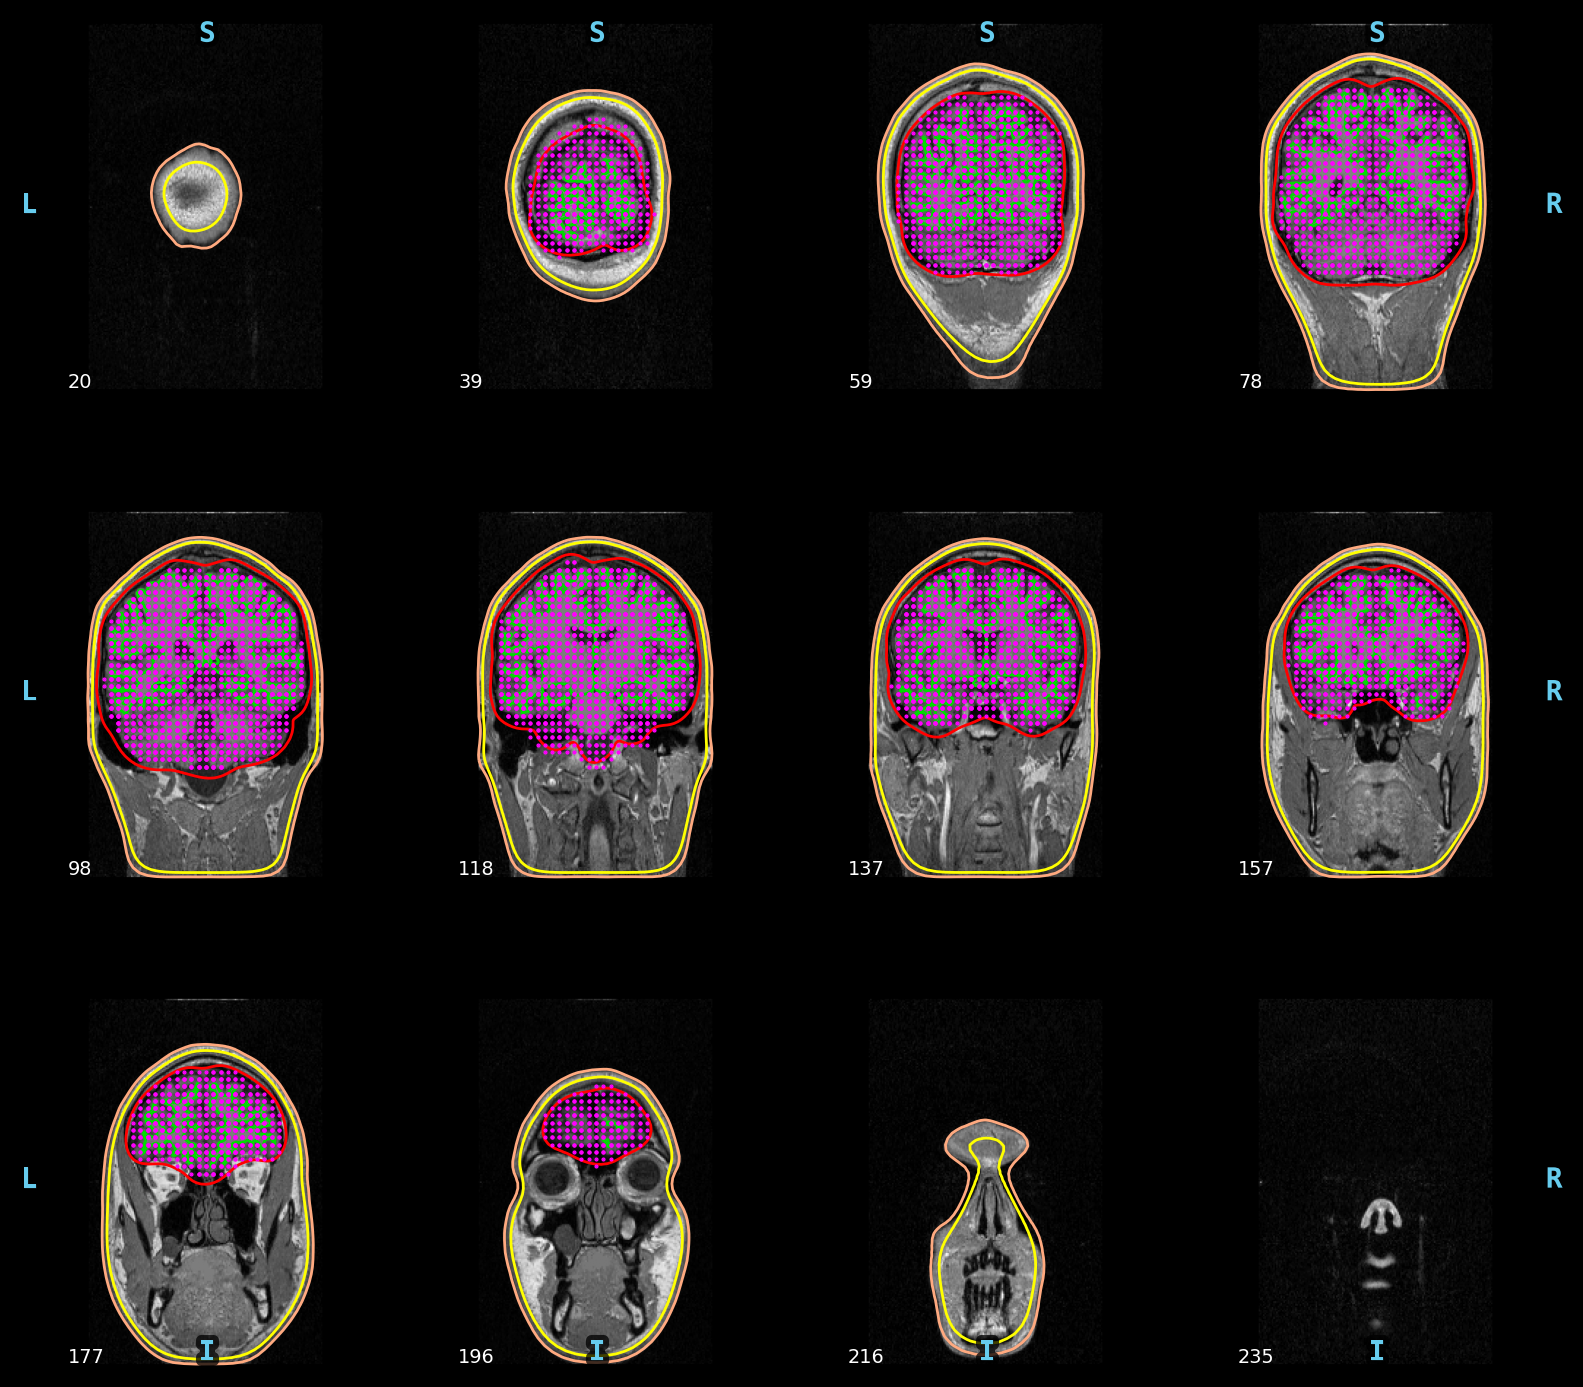

In [62]:
mne.viz.plot_bem(subject=fs_subject, 
                     subjects_dir=fs_root,
                     brain_surfaces='white', 
                     src=src, 
                     orientation='coronal')

Note that the grid converts the brain.

## Alignment checking

In [65]:
print(trans_file)

/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_trans1.fif


In [67]:
info = raw.info
print(info)
mne.viz.plot_alignment(info, 
                       trans=trans_file, 
                       subject=fs_subject,
                       dig=True,
                       meg=['helmet', 'sensors'],
                       subjects_dir=fs_root,
                       surfaces={"head": 0.1,"inner_skull": 0.2, "white": 1.0},
                       bem=bem,
                       src=src
                      )

<Info | 15 non-empty values
 bads: []
 ch_names: Trigger 1, Trigger 2, Trigger 3, Trigger 4, Trigger 5, Trigger ...
 chs: 27 Stimulus, 192 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 device_info: 2 items (dict)
 dig: 15603 items (3 Cardinal, 15600 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 219
 projs: []
 sfreq: 750.0 Hz
>
Could not find the surface for head in the provided BEM model, looking in the subject directory.
Using outer_skin.surf for head surface.
Getting helmet for system unknown (derived from 192 MEG channel locations)
Channel types::	mag: 192


<img src="https://raw.githubusercontent.com/FLUX-pipeline/Cerca/main/alignmentcheck.png">

## Construting the forward model

The last step is to construct the forward model by assigning a lead-field to each source location in relation to the head position with respect to the sensors. This will result in the lead-field matrix (fwd).

In [71]:
fwd = mne.make_forward_solution(info, 
                                trans=trans_file,
                                src=src, 
                                bem=bem,
                                meg=True, 
                                eeg=False, 
                                mindist=5.,  #TODO: minimum distance of sources from inner skull surface (in mm); can be 2.5
                                n_jobs=-1, 
                                verbose=True)

Source space          : <SourceSpaces: [<volume, shape=(31, 38, 33), n_used=12983>] MRI (surface RAS) coords, subject 'T1s', ~137.6 MiB>
MRI -> head transform : /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_trans1.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 12983 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999190 -0.040057 0.003942       2.09 mm
    0.030824 0.824468 0.565069      -2.64 mm
    -0.025885 -0.564490 0.825034       7.12 mm
    0.000000 0.000000 0.000000       1.00

Read 192 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994894 0.099619 -0.016189       1.27 mm
    -0.097025 0.988222 0.118333       9.89 mm
    0.027786 -0.116158 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    5.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    5.9s remaining:    3.5s


    Found     0/ 9186 points outside using solid angles
    Total 12983/12983 points inside the surface
Interior check completed in 6154.7 ms

Checking surface interior status for 192 points...
    Found   0/192 points inside  an interior sphere of radius   48.5 mm
    Found 162/192 points outside an exterior sphere of radius  100.0 mm
    Found  30/ 30 points outside using surface Qhull
    Found   0/  0 points outside using solid angles
    Total 0/192 points inside the surface
Interior check completed in 27.1 ms

Composing the field computation matrix...


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    4.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Computing MEG at 12983 source locations (free orientations)...


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/Users/o.jensen@bham.ac.uk/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    


Finished.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.2s finished


#### Finally, save the forward models:

In [72]:
mne.write_forward_solution(fwd_file, fwd, overwrite=True)

    Write a source space...
    [done]
    1 source spaces written


## Preregistraion and publications

Publication, example:

"Structural magnetic resonance images (MRIs) were acquired using a 3 Tesla Siemens MAGNETOM Prisma whole-body scanner (Siemens AG; TE = 2 ms, and TR = 2 s). The raw T1 weighted images were converted from DICOM to NIFTI. The MRIs were de-faced to anonymize the participant. The coordinate system of the participants' individual MRI was aligned to the anatomic landmarks (nasion as well as the left and right preauricular points) and the scalp shapes digitized before the recordings. The alignment according to the MEG sensor array was done relative to four digitized head position indicator (HPI) coils. A single shell boundary elements model (BEM) was constructed based on the brain surface derived using Freesurfer (Dale et al., 1999; Destrieux et al., 2010). This was then used to construct a volumetric forward model (5 mm grid) covering the full brain volume. The lead field matrix was then calculated according the head-position with respect to MEG sensor array. "



## References

- Dale, A.M., Fischl, B., & Sereno, M.I. (1999). Cortical surface-based analysis: I. Segmentation and surface reconstruction. *NeuroImage*, **9**(2), 179–194. https://doi.org/10.1006/nimg.1998.0395

- Destrieux, C., Fischl, B., Dale, A., & Halgren, E. (2010). Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature. *NeuroImage*, **53**(1), 1–15. https://doi.org/10.1016/j.neuroimage.2010.06.010
